<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Prediction_of_Dry_Ice_Sublimation_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [3]:
# @title 1) Setup for the dry ice prediction
# One chart per figure; matplotlib only; no explicit colors.

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["savefig.dpi"] = 250

In [4]:
# @title 2) Clausius–Clapeyron model (dataclass, T-independent ΔH_sub)
@dataclass(frozen=True)
class CO2SublimationModel:
    """Clausius–Clapeyron model for CO₂ sublimation pressure.

    Uses ln P(T) = -ΔH_sub/(R T) + C with C fixed by the triple point (T_t, P_t).
    Assumes ΔH_sub is weakly T-dependent over the plotted range and treats it
    as constant for this demonstration.

    Attributes:
        delta_h_sub_j_per_mol: Enthalpy of sublimation [J/mol].
        triple_t_k: Triple-point temperature [K].
        triple_p_pa: Triple-point pressure [Pa].
    """

    delta_h_sub_j_per_mol: float = 25.23e3  # ~25–26 kJ/mol near ~195 K
    triple_t_k: float = 216.58              # CO₂ triple point [K]
    triple_p_pa: float = 5.185e5            # CO₂ triple point [Pa] (5.185 bar)

    R_J_PER_MOLK: float = 8.314462618       # universal gas constant

    @property
    def _C(self) -> float:
        """Integration constant C for ln P(T) = -ΔH/(R T) + C, fixed at the triple point."""
        return math.log(self.triple_p_pa) + self.delta_h_sub_j_per_mol / (
            self.R_J_PER_MOLK * self.triple_t_k
        )

    def pressure_pa(self, T_K: np.ndarray | float) -> np.ndarray | float:
        """Return sublimation pressure P(T) in pascals."""
        T_arr = np.asarray(T_K, dtype=float)
        expo = -self.delta_h_sub_j_per_mol / (self.R_J_PER_MOLK * T_arr) + self._C
        return np.exp(expo)

    def predict_temperature_K(self, p_target_pa: float) -> float:
        """Return T [K] such that P_sub(T) = p_target_pa."""
        denom = self._C - math.log(p_target_pa)
        return self.delta_h_sub_j_per_mol / (self.R_J_PER_MOLK * denom)

=== Numerical Result ===
Predicted sublimation temperature @ 1 atm: 193.977 K  (-79.173 °C)
Reference value (not used in fit):         -78.500 °C
Absolute error:                             0.673 °C
Figure saved to: /content/co2_sublimation_ambient_prediction.png


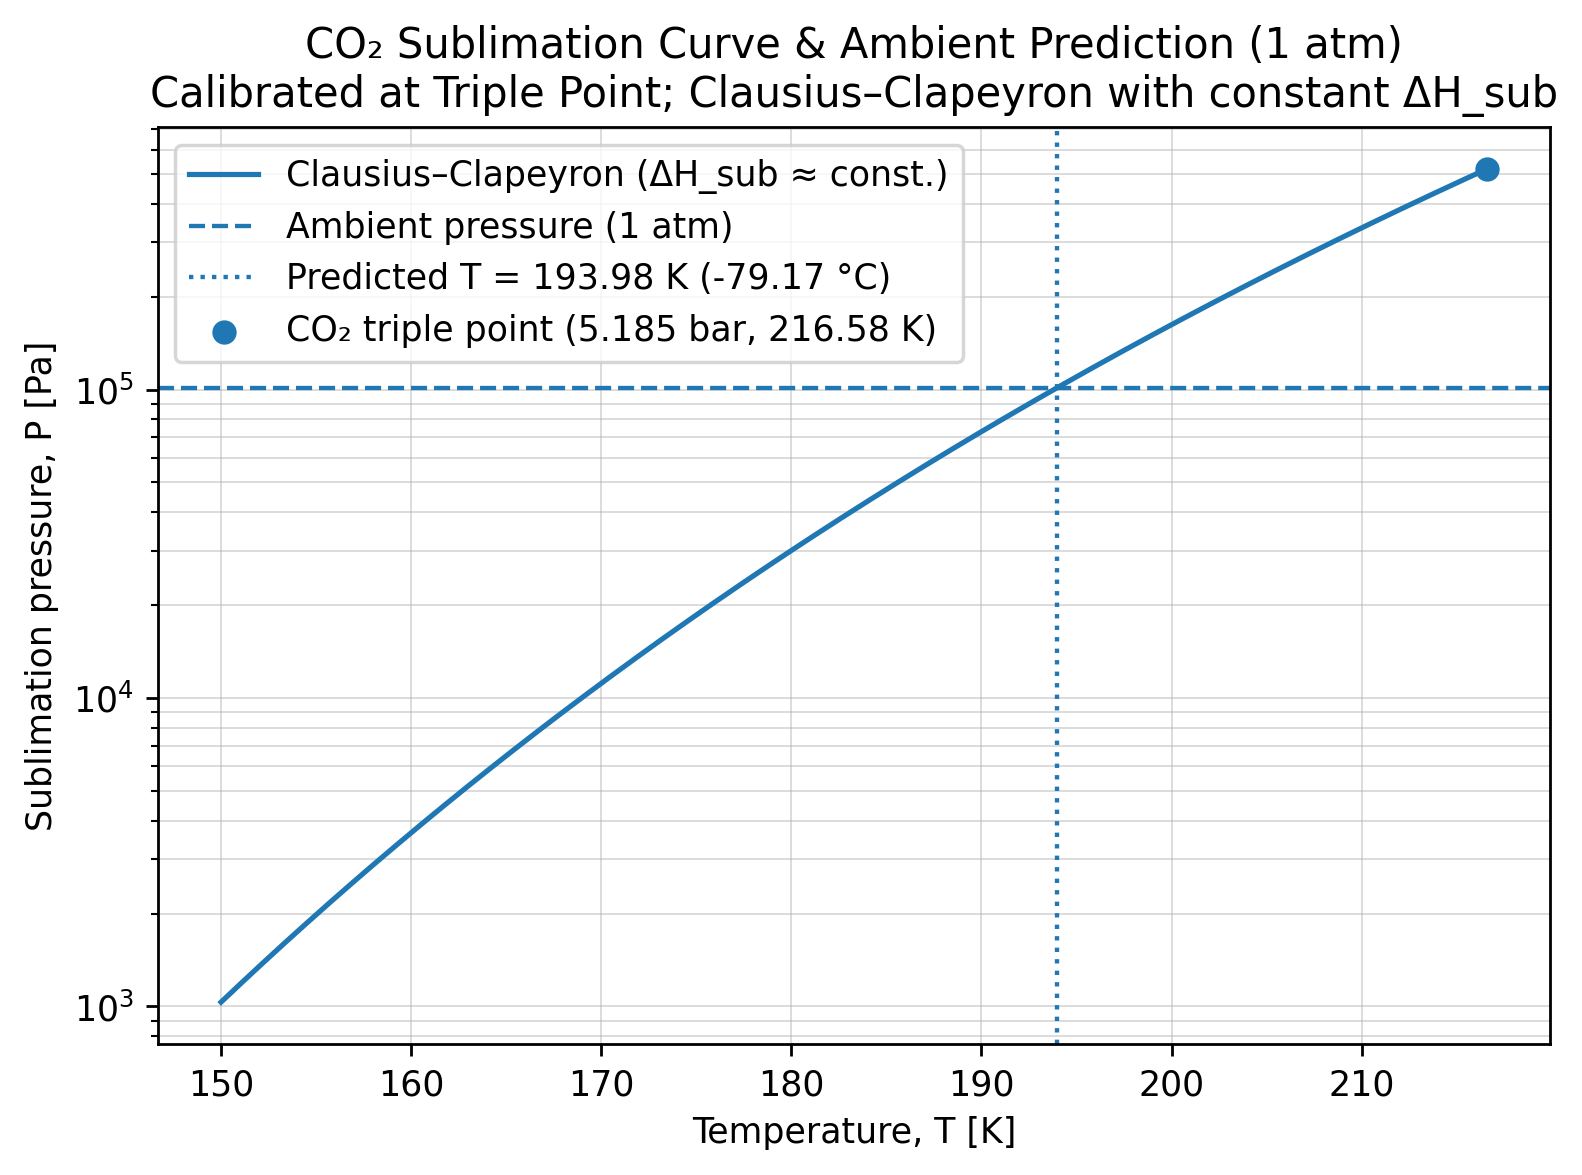

In [5]:
# @title 3) Control knobs → prediction → single-figure plot & save
# ---- Control knobs ----
AMBIENT_PRESSURE_PA = 101_325.0         # 1 atm
DELTA_H_SUB_J_PER_MOL = 25.23e3         # try 25.9e3–26.0e3 to tighten match
T_MIN_K, T_MAX_K = 150.0, 216.58        # up to triple point
N_POINTS = 600
SAVE_PATH = "/content/co2_sublimation_ambient_prediction.png"

# ---- Build model & predict T at 1 atm ----
model = CO2SublimationModel(delta_h_sub_j_per_mol=DELTA_H_SUB_J_PER_MOL)
T_pred_K = model.predict_temperature_K(AMBIENT_PRESSURE_PA)
T_pred_C = T_pred_K - 273.15

# Reference for comparison (not used in the fit)
T_ref_C = -78.5
abs_err_C = abs(T_pred_C - T_ref_C)

# ---- Generate curve ----
T_grid_K = np.linspace(T_MIN_K, T_MAX_K, N_POINTS)
P_grid_Pa = model.pressure_pa(T_grid_K)

# ---- Plot: one chart, no explicit colors ----
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.plot(T_grid_K, P_grid_Pa, label="Clausius–Clapeyron (ΔH_sub ≈ const.)")
ax.axhline(AMBIENT_PRESSURE_PA, linestyle="--", linewidth=1.25, label="Ambient pressure (1 atm)")
ax.axvline(T_pred_K, linestyle=":", linewidth=1.25,
           label=f"Predicted T = {T_pred_K:.2f} K ({T_pred_C:.2f} °C)")
ax.scatter([model.triple_t_k], [model.triple_p_pa], marker="o", zorder=3,
           label="CO₂ triple point (5.185 bar, 216.58 K)")

ax.set_yscale("log")
ax.set_xlabel("Temperature, T [K]")
ax.set_ylabel("Sublimation pressure, P [Pa]")
ax.set_title("CO₂ Sublimation Curve & Ambient Prediction (1 atm)\n"
             "Calibrated at Triple Point; Clausius–Clapeyron with constant ΔH_sub")
ax.grid(True, which="both", linewidth=0.5, alpha=0.5)
ax.legend()
fig.tight_layout()
fig.savefig(SAVE_PATH, dpi=250)

print("=== Numerical Result ===")
print(f"Predicted sublimation temperature @ 1 atm: {T_pred_K:.3f} K  ({T_pred_C:.3f} °C)")
print(f"Reference value (not used in fit):         {T_ref_C:.3f} °C")
print(f"Absolute error:                             {abs_err_C:.3f} °C")
print(f"Figure saved to: {SAVE_PATH}")

plt.show()


In [8]:
# @title 4) Calibrate ΔH_sub to hit a target temperature exactly (bisection)
# This demonstrates the mild sensitivity of the prediction to ΔH_sub.
TARGET_T_C = -78.5
TARGET_T_K = TARGET_T_C + 273.15

def predict_T_for(delta_h_sub_j_per_mol: float) -> float:
    """Helper: temperature [K] at 1 atm for a given ΔH_sub."""
    m = CO2SublimationModel(delta_h_sub_j_per_mol=delta_h_sub_j_per_mol)
    return m.predict_temperature_K(101_325.0)

# Simple bisection on ΔH_sub in a plausible bracket
lo, hi = 24.0e3, 27.0e3
for _ in range(40):
    mid = 0.5 * (lo + hi)
    T_mid = predict_T_for(mid)
    if (T_mid - TARGET_T_K) > 0.0:
        # If predicted T is too high, increase denominator → increase ΔH_sub
        hi = mid
    else:
        lo = mid

calibrated_dH = 0.5 * (lo + hi)
T_cal_K = predict_T_for(calibrated_dH)
T_cal_C = T_cal_K - 273.15

print("=== ΔH_sub calibration via bisection ===")
print(f"Calibrated ΔH_sub: {calibrated_dH/1e3:.3f} kJ/mol")
print(f"T(1 atm) with calibrated ΔH_sub: {T_cal_K:.3f} K  ({T_cal_C:.3f} °C)")

=== ΔH_sub calibration via bisection ===
Calibrated ΔH_sub: 26.095 kJ/mol
T(1 atm) with calibrated ΔH_sub: 194.650 K  (-78.500 °C)
